# Model construction

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

sys.path.append('../')
from src.constants import *
from src.utils import read_pickle, save_to_pickle, save_information

## Reading Data

In [21]:
df_train = pd.read_feather(TRANSFORMED_TRAIN_DATASET_PATH)
X_train = df_train.drop(columns=DUMMY_TARGET)
y_train = df_train[DUMMY_TARGET].values

df_test = pd.read_feather(TEST_DATASET_PATH)

transformer = read_pickle(TRANSFORMER_PATH)
scaler = read_pickle(SCALER_PATH)

numerical_features = transformer.numerical_variables
categorical_features = transformer.categorical_variables

In [3]:
df_train.head()

,age_of_client,num_of_years_of_education,capital_gain,capital_loss,hours_of_work_per_week,type_of_work_1,type_of_work_2,type_of_work_3,type_of_work_4,education_level_1,...,ocupation_2,ocupation_3,ocupation_4,type_of_relationship_1,type_of_relationship_2,type_of_relationship_3,type_of_race_1,sex_1,native_country_1,dummy_ernings_flag
6010,-0.240064,1.156268,-0.231036,-0.207431,-0.899661,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1
4461,-1.373699,-0.032259,-0.231036,-0.207431,-1.770779,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
8762,-0.315639,-0.428435,-0.231036,-0.207431,-0.028543,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
26437,-0.315639,-0.032259,2.651975,-0.207431,0.842574,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1
2952,-1.222548,-0.428435,-0.231036,-0.207431,-1.596556,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0


## Fit the model

In [4]:
%time

# Create a logistic regression model
model = LogisticRegression(penalty='l1', solver='liblinear')

param_grid = {
    'C' : np.logspace(-4, 4, 20)
}

grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True, scoring="roc_auc")

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
mask = np.abs(results["mean_train_score"] - results["mean_test_score"]) < 0.01
results = results[mask].sort_values("mean_test_score", ascending=False)
best_param = results.iloc[0]["params"]

best_model = LogisticRegression(penalty='l1', solver='liblinear', **best_param)

best_model.fit(X_train, y_train)

save_to_pickle(best_model, BEST_MODEL_PATH)

CPU times: total: 0 ns
Wall time: 0 ns


In [36]:
best_param

{'C': 1.623776739188721}

## Coefficients Analysis

In [9]:
features = X_train.columns.tolist()
coefficients = np.squeeze(best_model.coef_)
df_coef = pd.DataFrame({"feature": features, "coefficient": coefficients})
df_coef = df_coef.sort_values("coefficient", ascending=False)

In [12]:
df_coef["data_type"] = np.where(df_coef.feature.isin(numerical_features), "numerical", "categorical")

In [37]:
df_coef.style.hide()

feature,coefficient,data_type
marital_status_2,2.306760,categorical
ocupation_4,1.369528,categorical
type_of_relationship_3,1.194124,categorical
ocupation_3,1.120242,categorical
type_of_relationship_2,1.059258,categorical
type_of_work_3,1.021000,categorical
capital_gain,0.822077,numerical
education_level_6,0.723864,categorical
native_country_1,0.721989,categorical
ocupation_2,0.713112,categorical


In [18]:
def plot_by_data_type(data_type):
    mask = df_coef.data_type==data_type
    features = df_coef[mask].feature
    coefficients = df_coef[mask].coefficient

    fig, ax = plt.subplots()
    ax.bar(features, coefficients)
    ax.tick_params(axis='x', rotation=90)

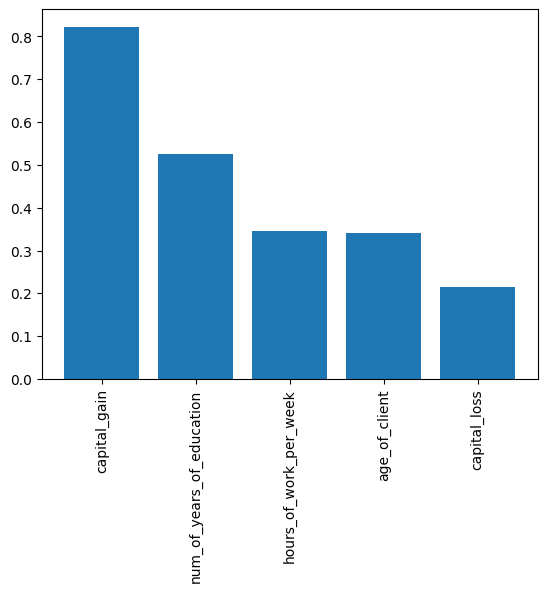

In [19]:
plot_by_data_type("numerical")

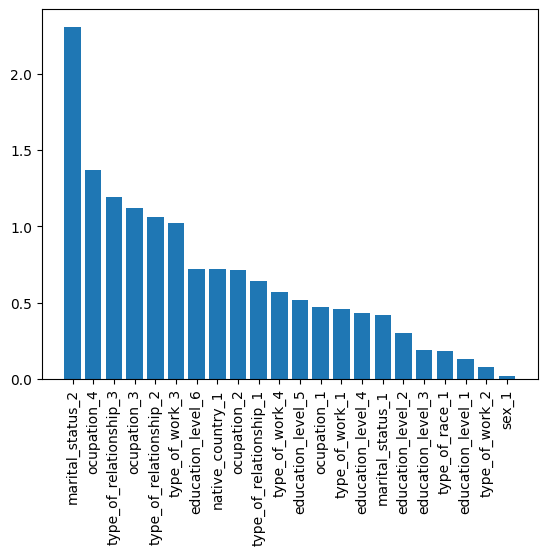

In [20]:
plot_by_data_type("categorical")

## Results on train set

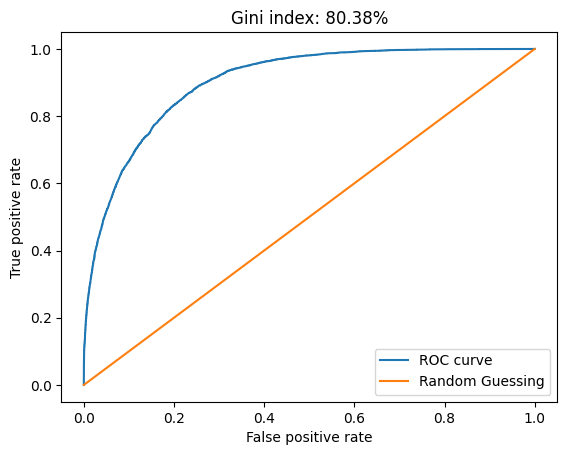

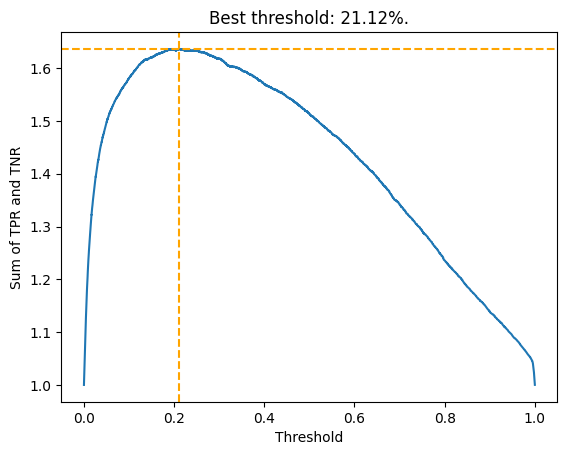

In [31]:
y_train_pred_prob = best_model.predict_proba(X_train)[:, 1]

def plot_graphs(y_true, y_pred, plot_second=False):
    gini = 2 * roc_auc_score(y_true, y_pred) - 1
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="ROC curve")
    ax.plot([0, 1], [0, 1], label="Random Guessing")
    ax.set(xlabel="False positive rate", ylabel="True positive rate", title=f"Gini index: {gini*100:.2f}%")
    ax.legend()
    plt.show()

    sum_tpr_tnr = tpr + (1 - fpr)
    idx = np.argmax(sum_tpr_tnr)
    best_threshold = thresholds[idx]
    max_value = sum_tpr_tnr[idx]

    if plot_second:

        fig, ax = plt.subplots()
        ax.plot(thresholds, sum_tpr_tnr)
        ax.axvline(best_threshold, color="orange", ls="--")
        ax.axhline(max_value, color="orange", ls="--")
        ax.set(xlabel="Threshold", ylabel="Sum of TPR and TNR", title=f"Best threshold: {best_threshold * 100:.2f}%.")
        plt.show()

    return best_threshold

best_threshold = plot_graphs(y_train, y_train_pred_prob, True)

In [6]:
y_train_pred_class = (y_train_pred_prob > best_threshold).astype(int)

report = classification_report(y_train, y_train_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     21847
           1       0.54      0.87      0.66      6731

    accuracy                           0.79     28578
   macro avg       0.74      0.82      0.76     28578
weighted avg       0.85      0.79      0.81     28578



## Results on test set

In [25]:
# obtaining original X_test and y_test

X_test = df_test.drop(columns=ORIGINAL_TARGET)
y_test = df_test[ORIGINAL_TARGET].values

# trasnforming

X_test = transformer.transform(X_test)
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

y_test = (y_test == POSITIVE_CLASS).astype(int)

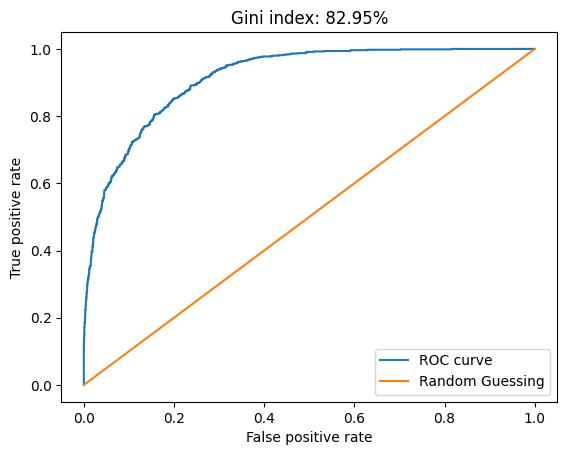

In [33]:
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

_ = plot_graphs(y_test, y_test_pred_proba)

In [35]:
y_test_pred_class = (y_test_pred_proba > best_threshold).astype(int)

report = classification_report(y_test, y_test_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.78      0.85      2456
           1       0.56      0.87      0.68       801

    accuracy                           0.80      3257
   macro avg       0.75      0.82      0.77      3257
weighted avg       0.85      0.80      0.81      3257

